### Keras & TensorFlow to Predict Market Movements and Backtesting

In [379]:
# %pip install seaborn
# %pip install yfinance
#%pip install pyfolio 


In [380]:
# make the necessary imports 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import warnings
import datetime
import pyfolio as pf
import backtrader as bt
from backtrader.feeds import PandasData
import warnings
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from talib import RSI, BBANDS, MACD

# set the style and ignore warnings
plt.style.use('seaborn-colorblind')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [381]:
# this is to display images in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Data Gathering

In [382]:
# ticker and the start and end dates for testing
ticker =  '^NSEI' # Nifty 50 benchmark
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2020, 8, 31)

In [383]:
# download ticker stock price from yahoo finance
stock =  yf.download(ticker, progress=True, actions=True,start=start, end=end)['Adj Close']
stock = pd.DataFrame(stock)
stock.rename(columns = {'Adj Close':'close'}, inplace=True)
stock.head(2)

[*********************100%%**********************]  1 of 1 completed


,close
Date,
2010-01-04,5232.200195
2010-01-05,5277.899902


In [384]:
# Calcula os retornos diários
stock['returns'] = np.log(stock['close'] / stock['close'].shift(1))

# Remove os NaN resultantes da operação
stock.dropna(inplace=True)

# Calcula a direção do mercado com base nos retornos
stock['direction'] = np.sign(stock['returns']).astype(int)

# Exibe as primeiras linhas do DataFrame
stock.head(3)

,close,returns,direction
Date,,,
2010-01-05,5277.899902,0.008696,1
2010-01-06,5281.799805,0.000739,1
2010-01-07,5263.100098,-0.003547,-1


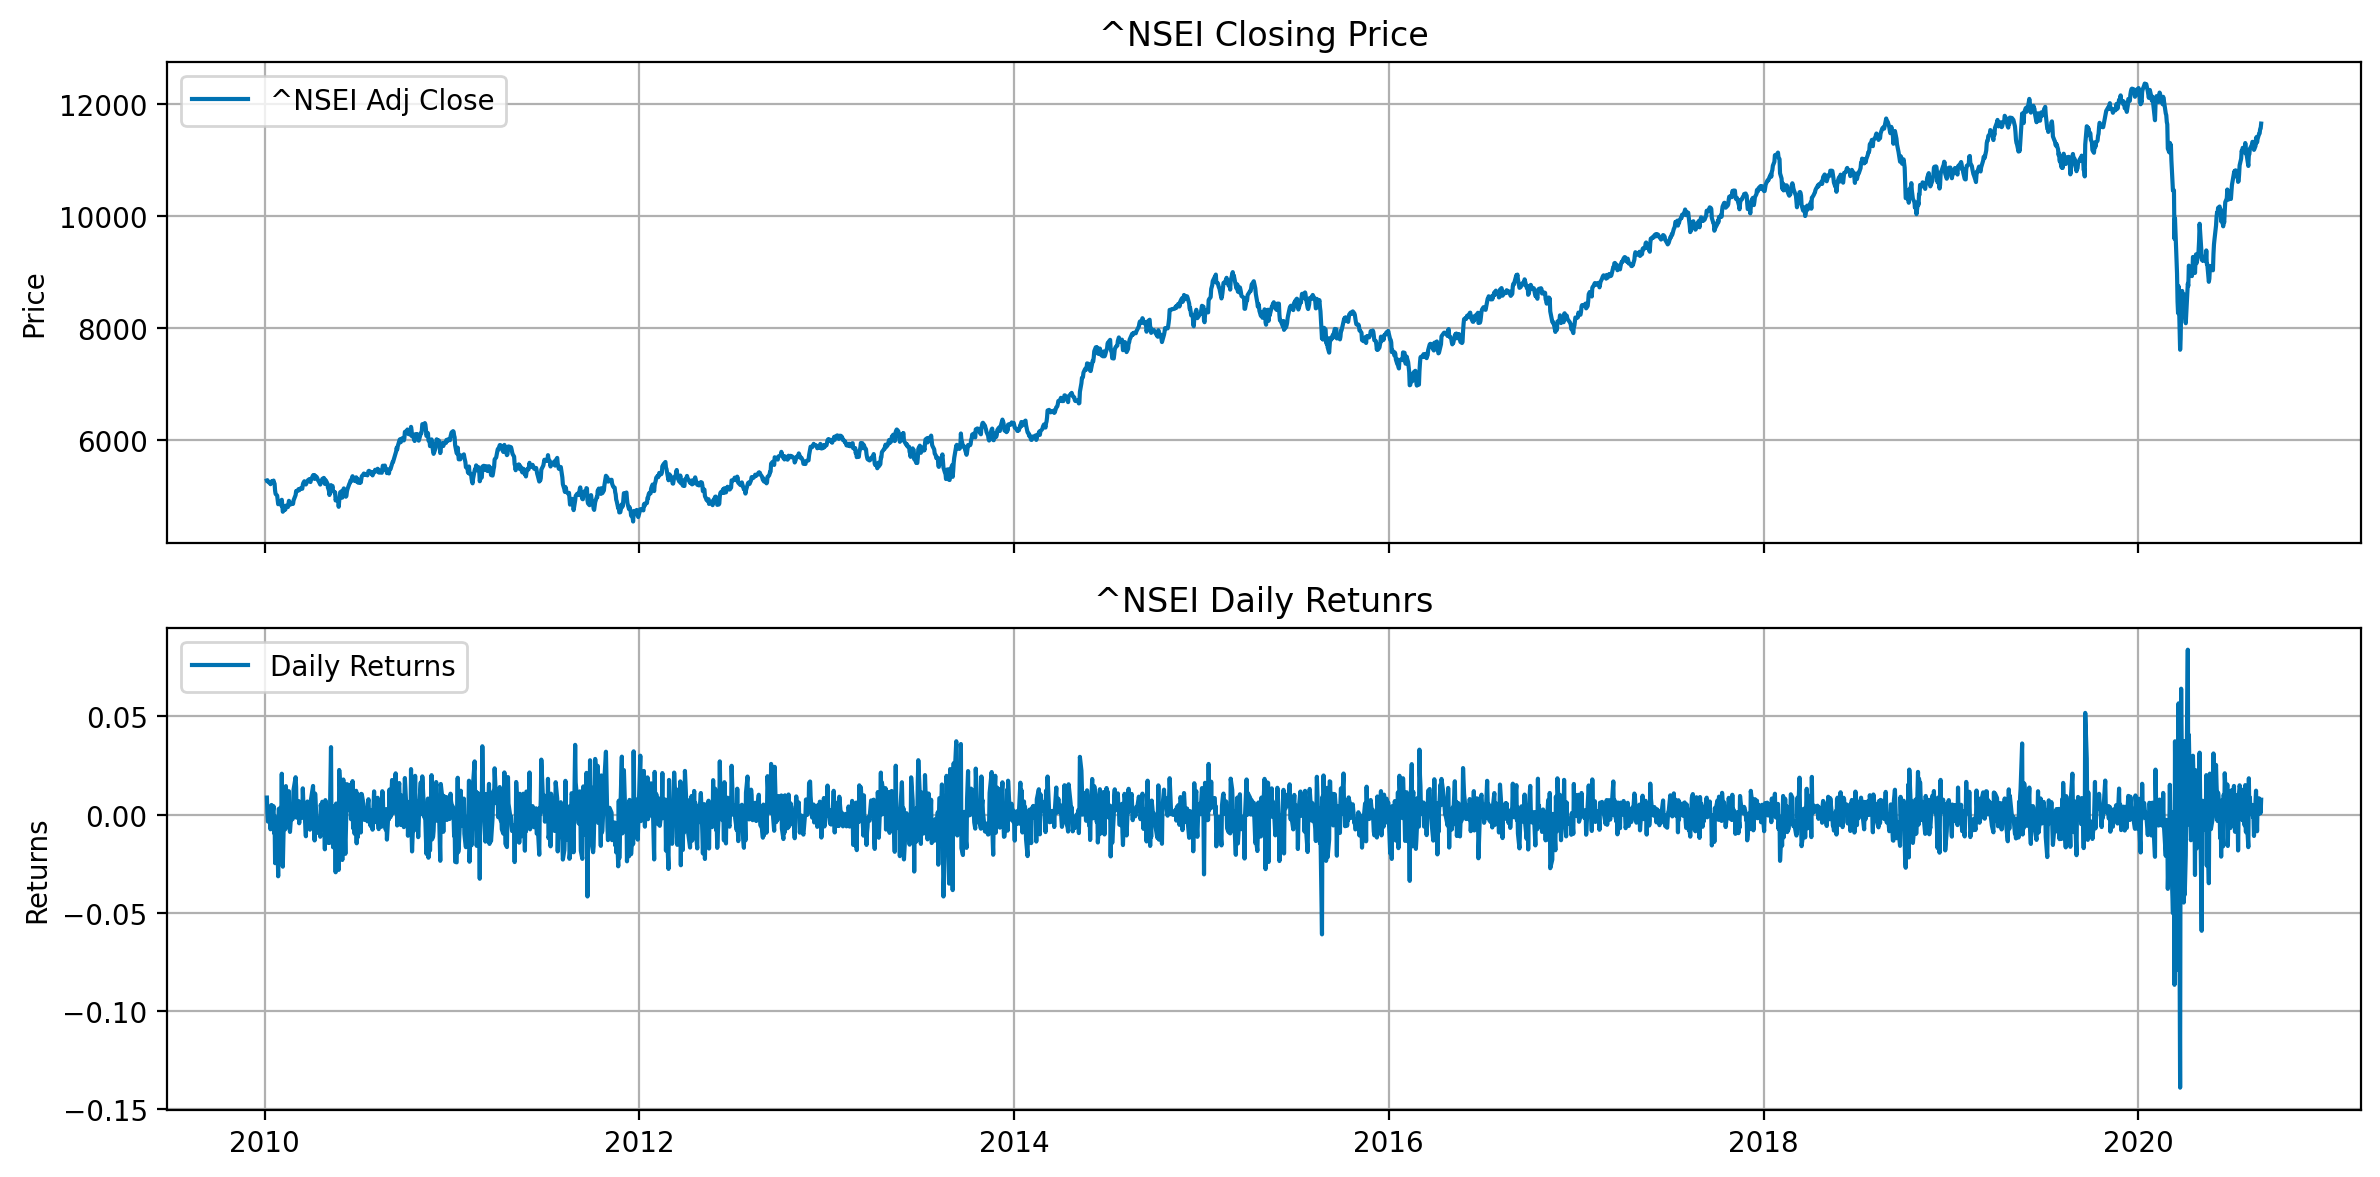

In [385]:
# visualize the closing price and daily returns
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(stock.close, label = f'{ticker} Adj Close')
ax[0].set(title = f'{ticker} Closing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(stock['returns'], label = 'Daily Returns')
ax[1].set(title = f'{ticker} Daily Retunrs', ylabel = 'Returns')
ax[1].grid(True)
plt.legend()

plt.tight_layout();
plt.savefig('images/chart1', dpi=300)

### Feature Engineering

In [386]:
# define the number of lags
lags = [1, 2, 3, 4, 5]

In [387]:
# compute lagged log returns
cols = []
for lag in lags:
    col = f'rtn_lag{lag}'
    stock[col] = stock['returns'].shift(lag)
    cols.append(col)
stock.head(2)

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5
Date,,,,,,,,
2010-01-05,5277.899902,0.008696,1,NaN,NaN,NaN,NaN,NaN
2010-01-06,5281.799805,0.000739,1,0.008696,NaN,NaN,NaN,NaN


In [388]:
# RSI - Relative Strenght Index
stock['rsi'] = RSI(stock.close)

# append to feature columns list
cols.append('rsi')
stock.tail(2)

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rsi
Date,,,,,,,,,
2020-08-27,11559.250000,0.000835,1,0.006720,0.000506,0.008306,0.005237,-0.008468,68.385929
2020-08-28,11647.599609,0.007614,1,0.000835,0.006720,0.000506,0.008306,0.005237,71.166549


In [389]:
# Compute Bollinger Bands
high, mid, low = BBANDS(stock.close, timeperiod=20)
stock = stock.join(pd.DataFrame({'bb_high': high, 'bb_low': low}, index=stock.index))

# append to feature columns list
cols.append('bb_high')
cols.append('bb_low')

In [390]:
# Compute Moving Average Convergence/ Divergence
stock['macd'] = MACD(stock.close)[0]

# append to feature columns list
cols.append('macd')
cols

['rtn_lag1',
 'rtn_lag2',
 'rtn_lag3',
 'rtn_lag4',
 'rtn_lag5',
 'rsi',
 'bb_high',
 'bb_low',
 'macd']

In [391]:
# # let's look at the head and tail of our dataframe
# stock.head().append(stock.tail())
stock

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rsi,bb_high,bb_low,macd
Date,,,,,,,,,,,,
2010-01-05,5277.899902,0.008696,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,5281.799805,0.000739,1,0.008696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,5263.100098,-0.003547,-1,0.000739,0.008696,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,5244.750000,-0.003493,-1,-0.003547,0.000739,0.008696,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,5249.399902,0.000886,1,-0.003493,-0.003547,0.000739,0.008696,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-24,11466.450195,0.008306,1,0.005237,-0.008468,0.002023,0.012217,0.006127,65.348755,11505.441931,10969.828186,152.569204
2020-08-25,11472.250000,0.000506,1,0.008306,0.005237,-0.008468,0.002023,0.012217,65.540203,11531.952273,10960.487864,154.145413
2020-08-26,11549.599609,0.006720,1,0.000506,0.008306,0.005237,-0.008468,0.002023,68.073644,11577.360320,10949.754817,159.794031


### Build and Apply the Model

In [392]:
# len(cols)

In [393]:
# split the dataset in training and test datasets
train, test = train_test_split(stock.dropna(), test_size=0.4, shuffle=False)

# sort the data on date index
train = train.copy().sort_index()
test = test.copy().sort_index()

In [394]:
# # view train dataset
train.tail()

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rsi,bb_high,bb_low,macd
Date,,,,,,,,,,,,
2016-06-13,8110.600098,-0.007303,-1,-0.004098,-0.008430,0.000798,0.007943,-0.002405,55.740105,8430.082564,7681.737358,101.218350
2016-06-14,8108.850098,-0.000216,-1,-0.007303,-0.004098,-0.008430,0.000798,0.007943,55.583093,8433.740612,7699.889320,90.665486
2016-06-15,8206.599609,0.011983,1,-0.000216,-0.007303,-0.004098,-0.008430,0.000798,62.018757,8443.741555,7723.533347,89.162030
2016-06-16,8140.750000,-0.008056,-1,0.011983,-0.000216,-0.007303,-0.004098,-0.008430,56.119687,8434.704335,7768.305577,81.715057
2016-06-17,8170.200195,0.003611,1,-0.008056,0.011983,-0.000216,-0.007303,-0.004098,58.041877,8414.838206,7830.221706,77.298611


In [395]:
# # view test dataset
test.tail()

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rsi,bb_high,bb_low,macd
Date,,,,,,,,,,,,
2020-08-24,11466.450195,0.008306,1,0.005237,-0.008468,0.002023,0.012217,0.006127,65.348755,11505.441931,10969.828186,152.569204
2020-08-25,11472.250000,0.000506,1,0.008306,0.005237,-0.008468,0.002023,0.012217,65.540203,11531.952273,10960.487864,154.145413
2020-08-26,11549.599609,0.006720,1,0.000506,0.008306,0.005237,-0.008468,0.002023,68.073644,11577.360320,10949.754817,159.794031
2020-08-27,11559.250000,0.000835,1,0.006720,0.000506,0.008306,0.005237,-0.008468,68.385929,11616.047368,10956.777730,163.168404
2020-08-28,11647.599609,0.007614,1,0.000835,0.006720,0.000506,0.008306,0.005237,71.166549,11664.953214,10965.286825,171.000506


To know more about keras and TF, please refer to https://keras.io/

In [396]:
# define a function to create the deep neural network model
def create_model():
    np.random.seed(100)
    tf.random.set_seed(100)
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=len(cols)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', #'rmsprop', 
                  metrics=['accuracy'])
    return model

In [397]:
# normalized the training dataset
mu, std = train.mean(), train.std()
train_ = (train - mu) / mu.std()

In [398]:
# create the model
model = create_model()

In [399]:
# map market direction of (1,-1) to (1,0)
train['direction_'] = np.where(train['direction'] > 0, 1, 0)

In [400]:
# cols

In [401]:
# train_.head()

In [402]:
%%time
# fit the model for training dataset
r = model.fit(train_[cols], train['direction_'], epochs=50, verbose=False)

CPU times: user 1.95 s, sys: 453 ms, total: 2.4 s
Wall time: 1.74 s


In [403]:
# normalized the test dataset
mu, std = test.mean(), test.std()
test_ = (test - mu) / std

In [404]:
# map market direction of (1,-1) to (1,0)
test['direction_'] = np.where(test['direction'] > 0, 1, 0)

In [405]:
# evaluate the model with test dataset
model.evaluate(test_[cols], test['direction_'])

33/33 [==============================] - 0s 534us/step - loss: 29.7001 - accuracy: 0.6291


[29.700056076049805, 0.6291261911392212]

In [406]:
# predict the direction and map it (1,0)
pred = np.where(model.predict(test_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

33/33 [==============================] - 0s 468us/step


array([1, 1, 1, 1, 0, 0, 0, 1, 1, 1])

In [407]:
# based on prediction calculate the position for strategy
test['position_strategy'] = np.where(pred > 0, 1, -1)

In [408]:
test['position_strategy']

Date
2016-06-20    1
2016-06-21    1
2016-06-22    1
2016-06-23    1
2016-06-24   -1
             ..
2020-08-24    1
2020-08-25    1
2020-08-26    1
2020-08-27    1
2020-08-28    1
Name: position_strategy, Length: 1030, dtype: int64

In [409]:
# calculate daily returns for the strategy
test['strategy_return_percent'] = (test['position_strategy'] * test['returns']) 

In [410]:
temp_df = test.copy()   
temp_df['close'] = test['close'].shift(1)

test['strategy_return_dolar'] = (test['position_strategy'] * test['returns'] * temp_df['close']) - (temp_df['close']) * 0.001

#test['strategy_return_dolar'] = (test['position_strategy'] * test['returns'] * test['close']) - (test['close'])*0.001

In [411]:
# # Aplicar a operação somente quando 'position_strategy' for igual a 1
# test['strategy_return'] = np.where(test['position_strategy'] == 1, (test['position_strategy'] * test['returns']) - (test['position_strategy'] * 0.001), 0)

In [412]:
# calculate total return and std. deviation of each strategy
#print('\nTotal Returns:')
print(test[['returns', 'strategy_return_percent']].sum().apply(np.exp))

soma_bruto = test[['strategy_return_dolar']].sum();
print(soma_bruto)
precent_lucro_em_btcs=soma_bruto/11647.599609*100
print("Sendo a operação de 1BTC por dia, a estratégia fez ", precent_lucro_em_btcs)
print("isso é a porcentagem em 4 anos.")
percent_ao_mes = (precent_lucro_em_btcs/100)**(1/48)
print("Média mensal de lucro: ", percent_ao_mes)

# print('\nAnnual Volatility:')
# print(test[['returns', 'strategy_return']].std() * 252 ** 0.5)

returns                     1.425620
strategy_return_percent    15.739627
dtype: float64
strategy_return_dolar    17974.328882
dtype: float64
Sendo a operação de 1BTC por dia, a estratégia fez  strategy_return_dolar    154.317881
dtype: float64
isso é a porcentagem em 4 anos.
Média mensal de lucro:  strategy_return_dolar    1.009079
dtype: float64


In [413]:
# number of trades over time for the strategy
print('Number of trades = ', (test['position_strategy'].diff()!=0).sum())

Number of trades =  163


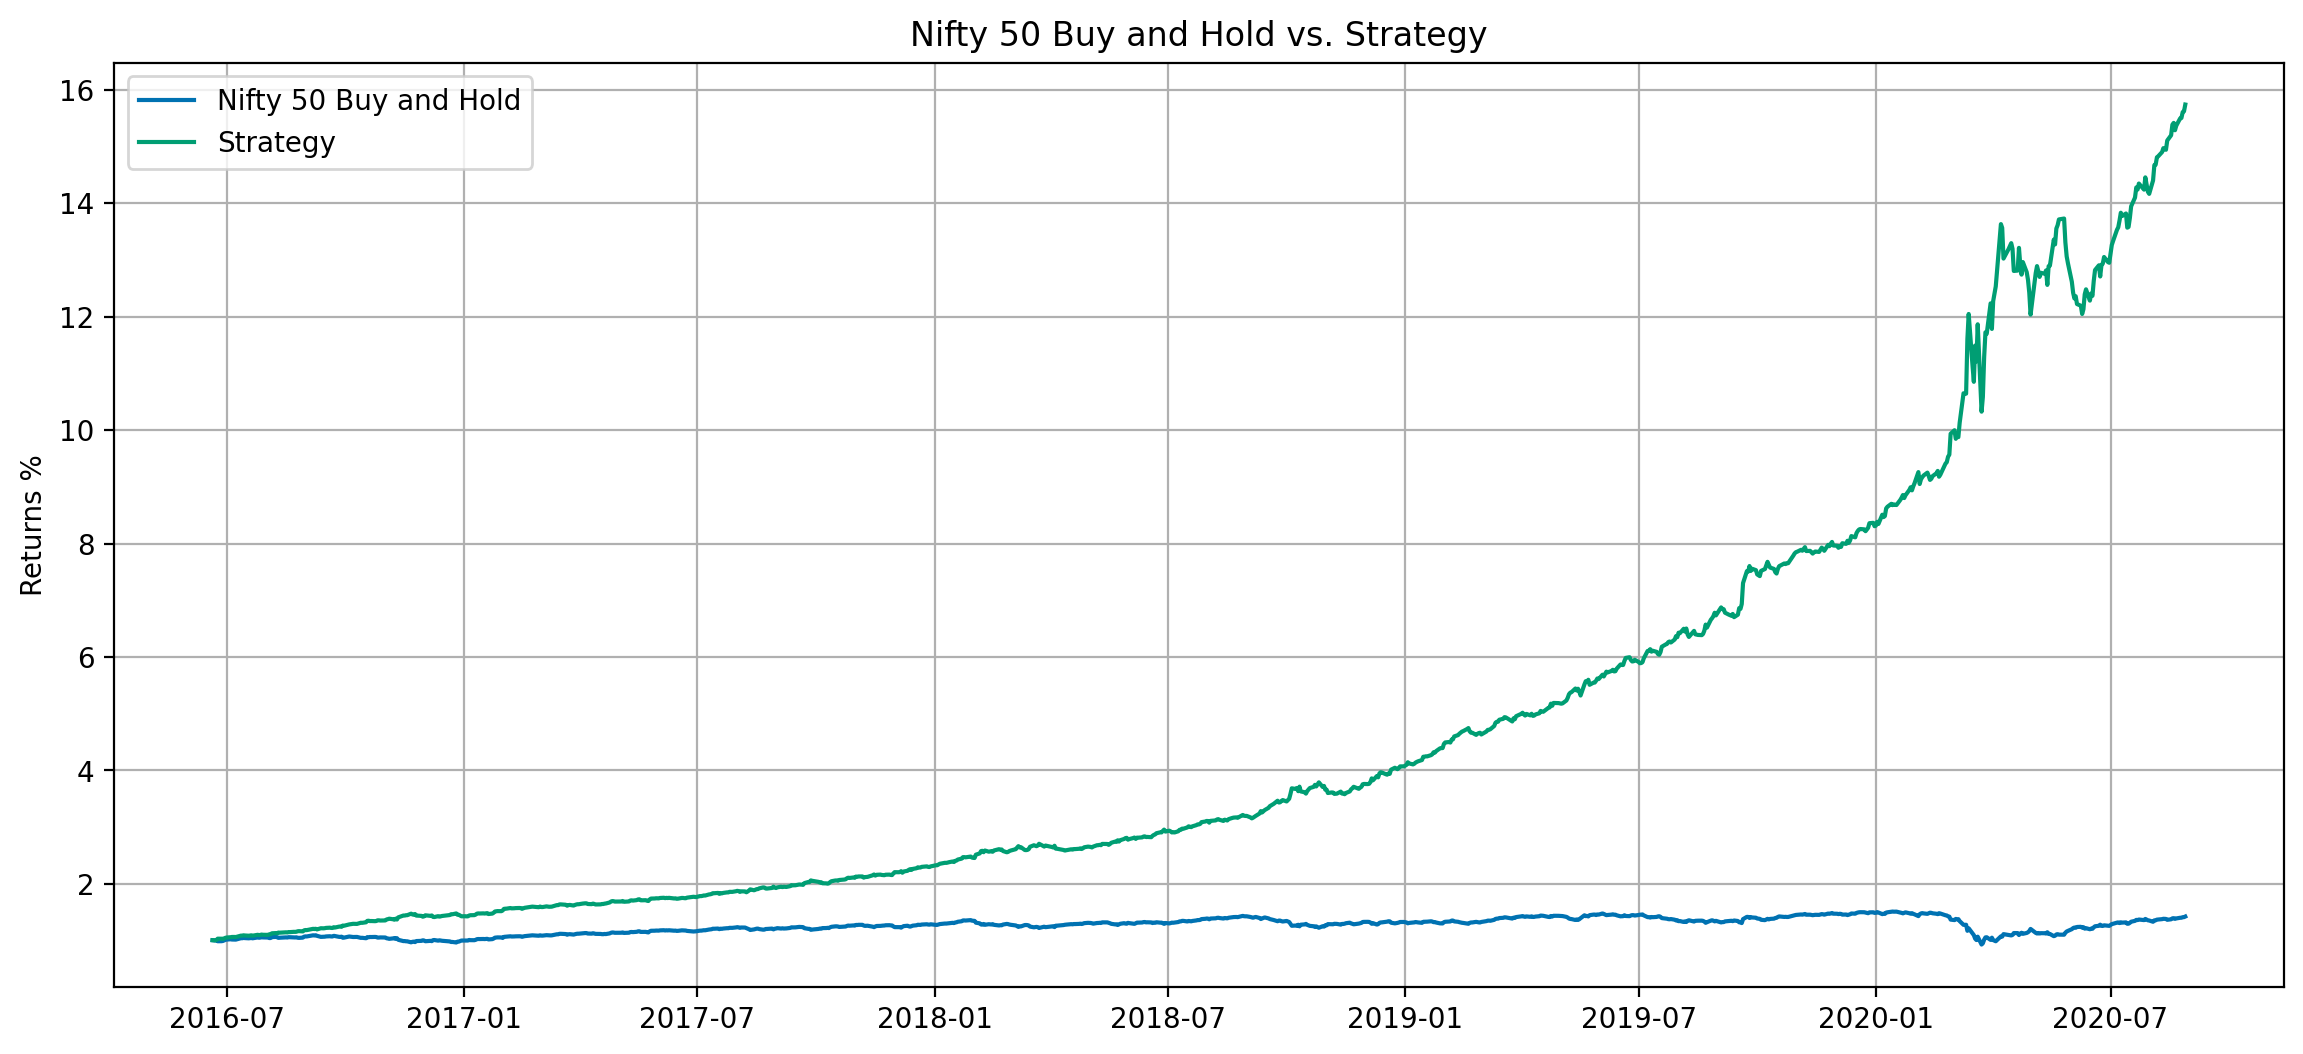

In [414]:
# plot cumulative returns
fig, ax = plt.subplots(1, 1, sharex=True, figsize = (14,6))
ax.plot(test.returns.cumsum().apply(np.exp), label = 'Nifty 50 Buy and Hold')
ax.plot(test.strategy_return_percent.cumsum().apply(np.exp), label = 'Strategy')
ax.set(title = 'Nifty 50 Buy and Hold vs. Strategy', ylabel = 'Returns %')
ax.grid(True)
ax.legend()
plt.savefig('images/chart2');

### Backtesting using Backtrader

In [415]:
# backtesting start and end dates
start = test.index[0]
end = test.index[-1]
print(start)
print(end)

2016-06-20 00:00:00
2020-08-28 00:00:00


In [416]:
# fetch the daily pricing data from yahoo finance
prices =  yf.download(ticker, progress=True, actions=True, start=start, end=end)
prices.head(2)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2016-06-20,8115.750000,8244.150391,8107.350098,8238.500000,8238.500000,168600,0.0,0.0
2016-06-21,8255.400391,8257.250000,8202.150391,8219.900391,8219.900391,137000,0.0,0.0


In [417]:
# rename the columns as needed for Backtrader
prices.drop(['Close','Dividends','Stock Splits'], inplace=True, axis=1)
prices.rename(columns = {'Open':'open','High':'high','Low':'low','Adj Close':'close','Volume':'volume',
                         }, inplace=True)

In [418]:
prices.head(3)

,open,high,low,close,volume
Date,,,,,
2016-06-20,8115.750000,8244.150391,8107.350098,8238.500000,168600
2016-06-21,8255.400391,8257.250000,8202.150391,8219.900391,137000
2016-06-22,8213.650391,8238.349609,8153.250000,8203.700195,136100


In [419]:
# add the predicted column to prices dataframe. This will be used as signal for buy or sell
predictions = test.position_strategy
predictions = pd.DataFrame(predictions)
predictions.rename(columns = {'position_strategy':'predicted'}, inplace=True)
prices = predictions.join(prices, how='right').dropna()
prices.head(10)

,predicted,open,high,low,close,volume
Date,,,,,,
2016-06-20,1,8115.750000,8244.150391,8107.350098,8238.500000,168600
2016-06-21,1,8255.400391,8257.250000,8202.150391,8219.900391,137000
2016-06-22,1,8213.650391,8238.349609,8153.250000,8203.700195,136100
2016-06-23,1,8201.150391,8285.599609,8188.299805,8270.450195,154100
2016-06-24,-1,8029.100098,8100.700195,7927.049805,8088.600098,297600
2016-06-27,-1,8039.350098,8120.649902,8039.350098,8094.700195,162500
2016-06-28,-1,8096.049805,8146.350098,8086.850098,8127.850098,170400
2016-06-29,1,8173.100098,8212.400391,8157.649902,8204.000000,147000
2016-06-30,1,8260.250000,8308.150391,8242.099609,8287.750000,279400


In [420]:
#prices[['predicted']].sum().apply(np.exp)

In [421]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [422]:
# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

## Strategy: 

In [423]:
# Import da estratégia escrita em outro arquivo
from long_and_short_strat import MLStrategy
#from long_strat import MLStrategy

In [424]:
# instantiate SignalData class
data = SignalData(dataname=prices)

In [425]:
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(MLStrategy)
cerebro.adddata(data, name=ticker)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [426]:
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2016-06-21, LONG CREATED --- Size: 12, Cash: 100000.00, Open: 8255.400390625, Close: 8219.900390625
2016-06-24, CLOSE LONG POSITION --- Size: 12
2016-06-24, OPERATION RESULT --- Gross: -2715.60, Net: -2911.02
2016-06-27, SHORT CREATED --- Size: 12, Cash: 97088.98, Open: 8039.35009765625, Close: 8094.7001953125
2016-06-29, CLOSE SHORT POSITION --- Size: 12
2016-06-29, Order Failed
2016-06-29, OPERATION RESULT --- Gross: -1605.00, Net: -1799.55
2016-06-30, LONG CREATED --- Size: 11, Cash: 95289.43, Open: 8260.25, Close: 8287.75
2016-07-05, CLOSE LONG POSITION --- Size: 11
2016-07-05, OPERATION RESULT --- Gross: 1309.55, Net: 1126.51
2016-07-07, LONG CREATED --- Size: 11, Cash: 96415.95, Open: 8342.0, Close: 8337.900390625
2016-08-03, CLOSE LONG POSITION --- Size: 11
2016-08-03, OPERATION RESULT --- Gross: 3225.20, Net: 3038.45
2016-08-04, LONG CREATED --- Size: 11, Cash: 99454.40, Open: 8599.9501953125, Close: 8551.099609375
2016-08-10, CLOSE LONG POSI

In [427]:
# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
returns.head(10)

index
2016-06-20 00:00:00+00:00    0.000000
2016-06-21 00:00:00+00:00   -0.005251
2016-06-22 00:00:00+00:00   -0.001954
2016-06-23 00:00:00+00:00    0.008068
2016-06-24 00:00:00+00:00   -0.029901
2016-06-27 00:00:00+00:00   -0.007835
2016-06-28 00:00:00+00:00   -0.004130
2016-06-29 00:00:00+00:00   -0.006683
2016-06-30 00:00:00+00:00    0.002221
2016-07-01 00:00:00+00:00    0.004676
Name: Strategy, dtype: float64

In [428]:
# get benchmark returns
benchmark_rets= stock['returns']
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'Nifty-50'
benchmark_rets.head(2)

Date
2016-06-20 00:00:00+00:00    0.008325
2016-06-21 00:00:00+00:00   -0.002260
Name: Nifty-50, dtype: float64

In [429]:
# returns.index = returns.index.date
returns

index
2016-06-20 00:00:00+00:00    0.000000
2016-06-21 00:00:00+00:00   -0.005251
2016-06-22 00:00:00+00:00   -0.001954
2016-06-23 00:00:00+00:00    0.008068
2016-06-24 00:00:00+00:00   -0.029901
                               ...   
2020-08-21 00:00:00+00:00    0.005128
2020-08-24 00:00:00+00:00    0.008147
2020-08-25 00:00:00+00:00    0.000494
2020-08-26 00:00:00+00:00    0.006587
2020-08-27 00:00:00+00:00    0.000816
Name: Strategy, Length: 1029, dtype: float64

In [430]:
# # Suponha que 'returns' seja a sua Series de retornos
# returns = pd.DataFrame({'Returns': returns})
returns
# Agora, chame a função create_full_tear_sheet com o DataFrame
pf.show_perf_stats(returns)

Start date,2016-06-20
End date,2020-08-27
Total months,49
,Backtest
Annual return,27.8%
Cumulative returns,172.1%
Annual volatility,15.6%
Sharpe ratio,1.65
Calmar ratio,2.16
Stability,0.94
Max drawdown,-12.9%


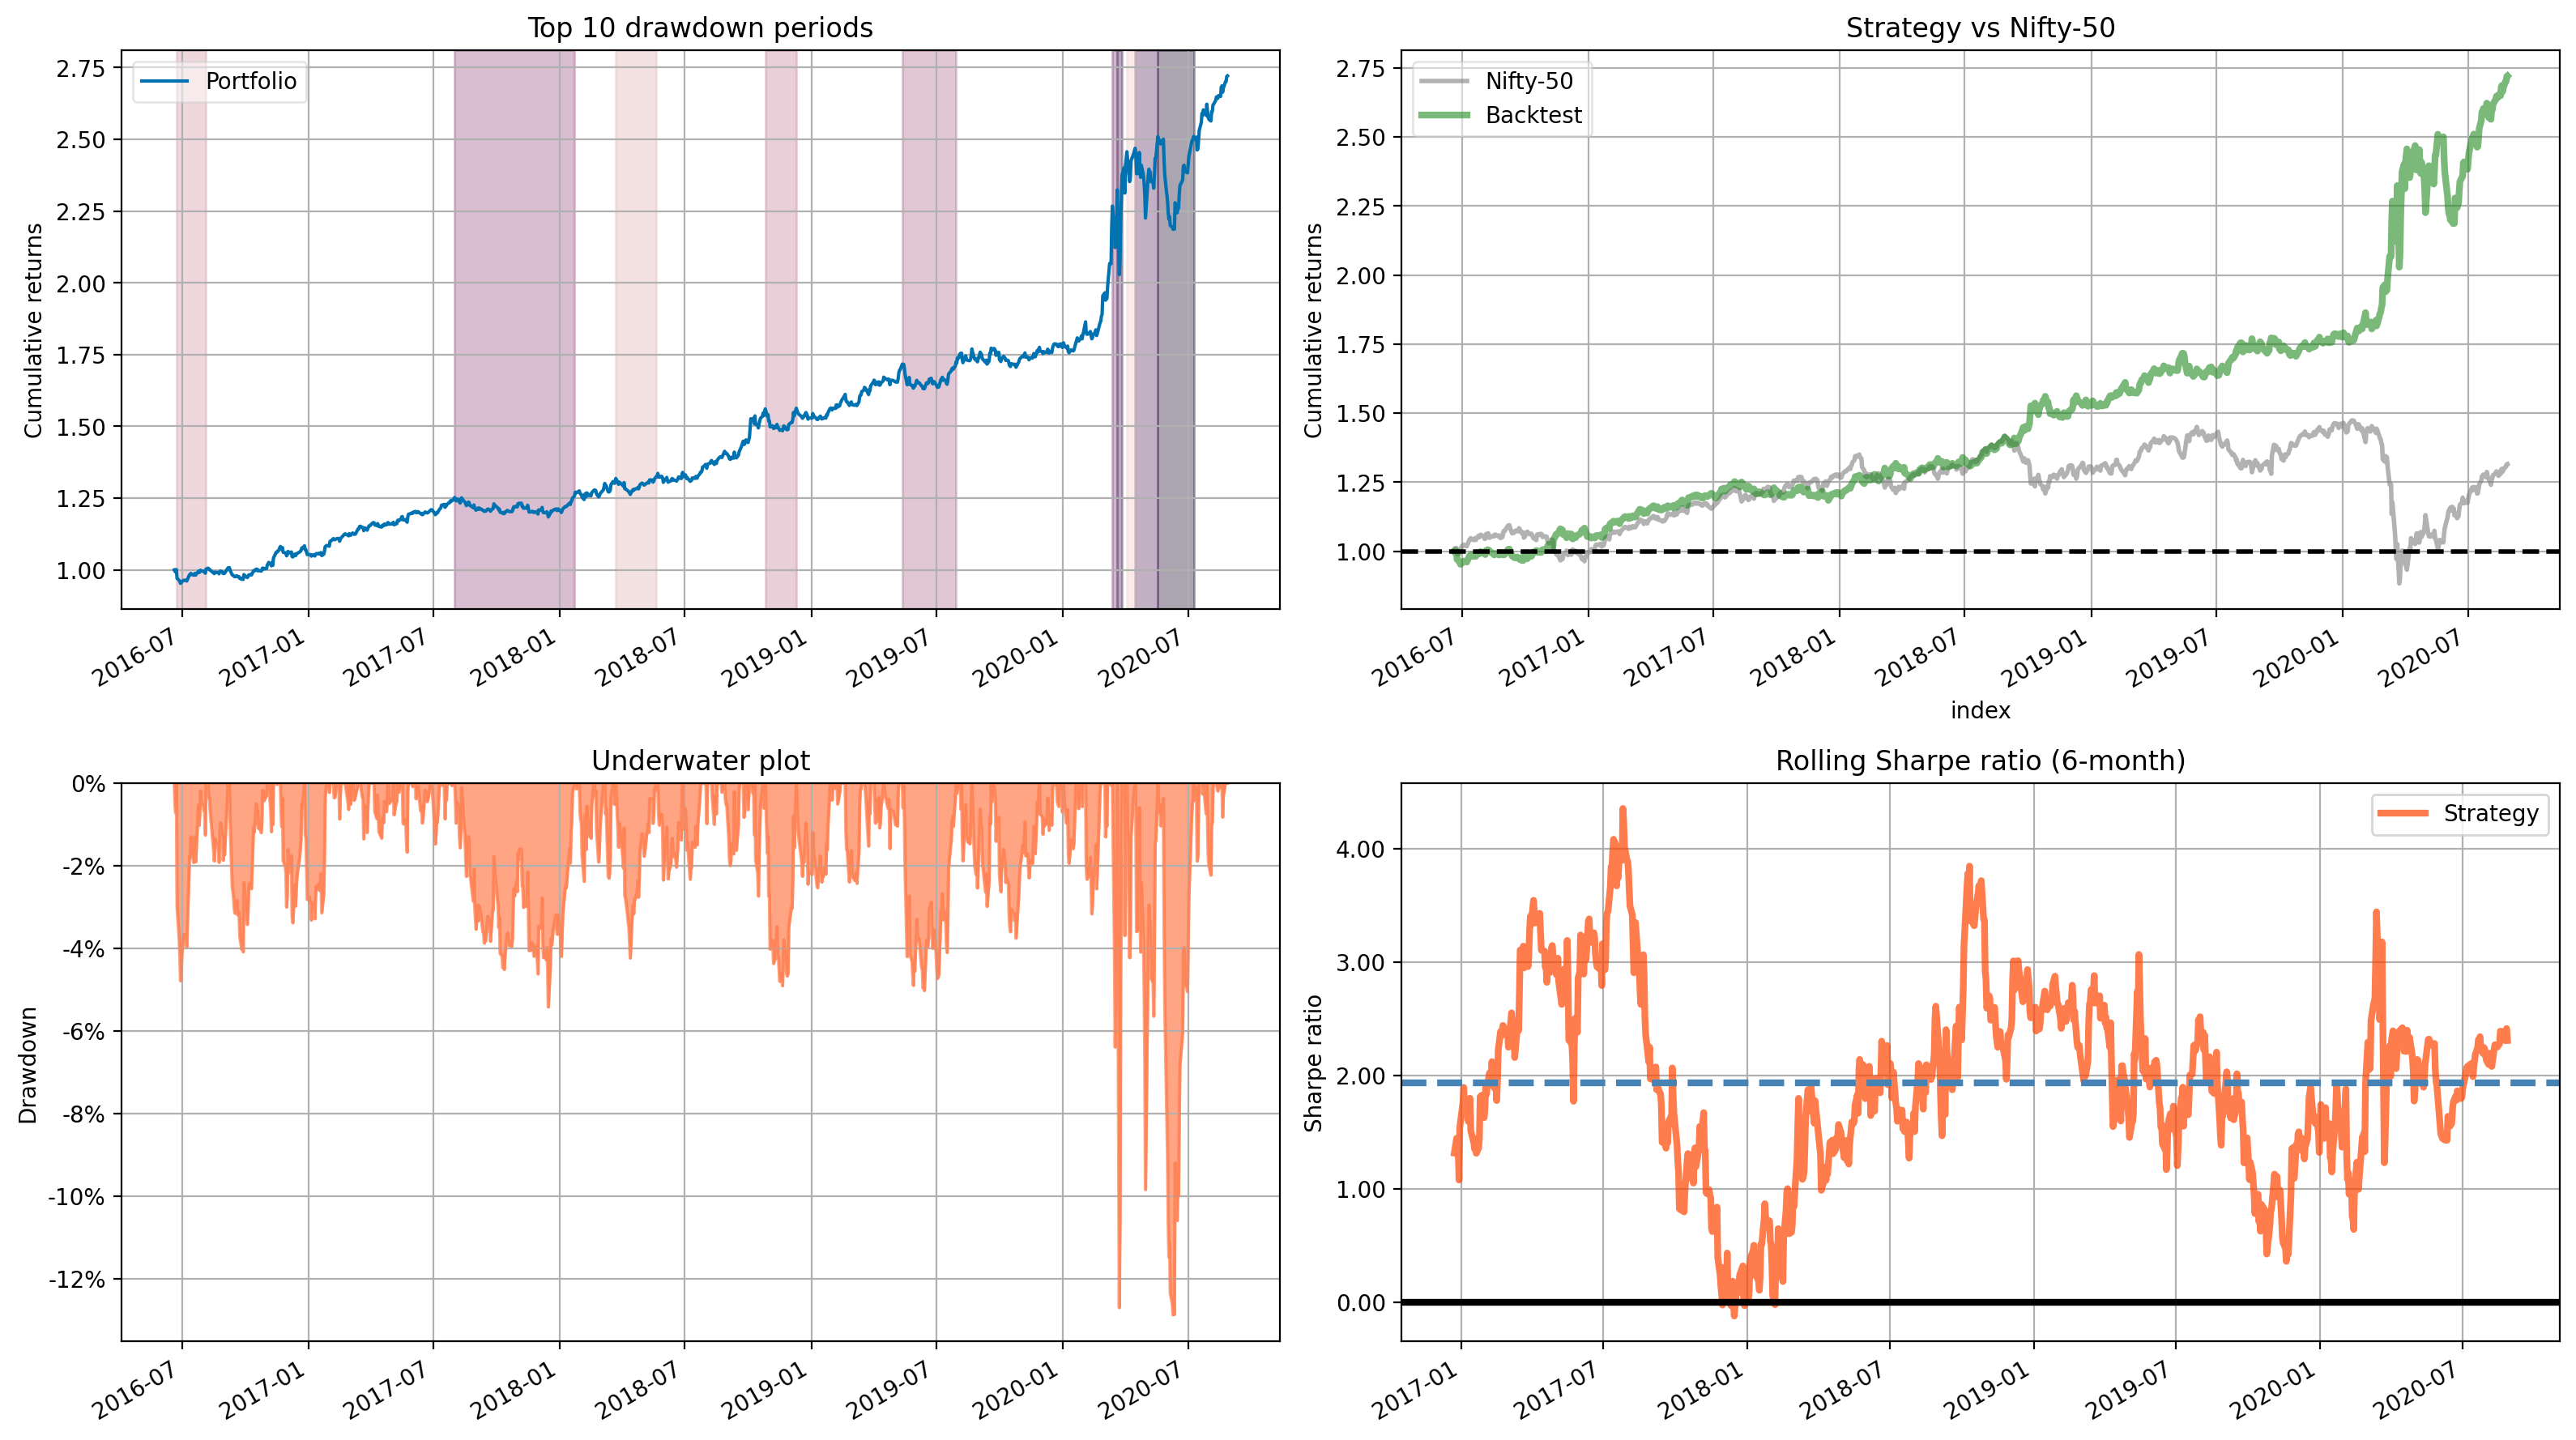

In [431]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()


pf.plot_drawdown_periods(returns=returns, ax=axes[0])
axes[0].grid(True)
pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[1], title='Strategy vs Nifty-50')
axes[1].grid(True)
pf.plot_drawdown_underwater(returns=returns, ax=axes[2])
axes[2].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[3])
axes[3].grid(True)
# fig.suptitle('XXX', fontsize=16, y=0.990)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('images/chart3', dpi=300)

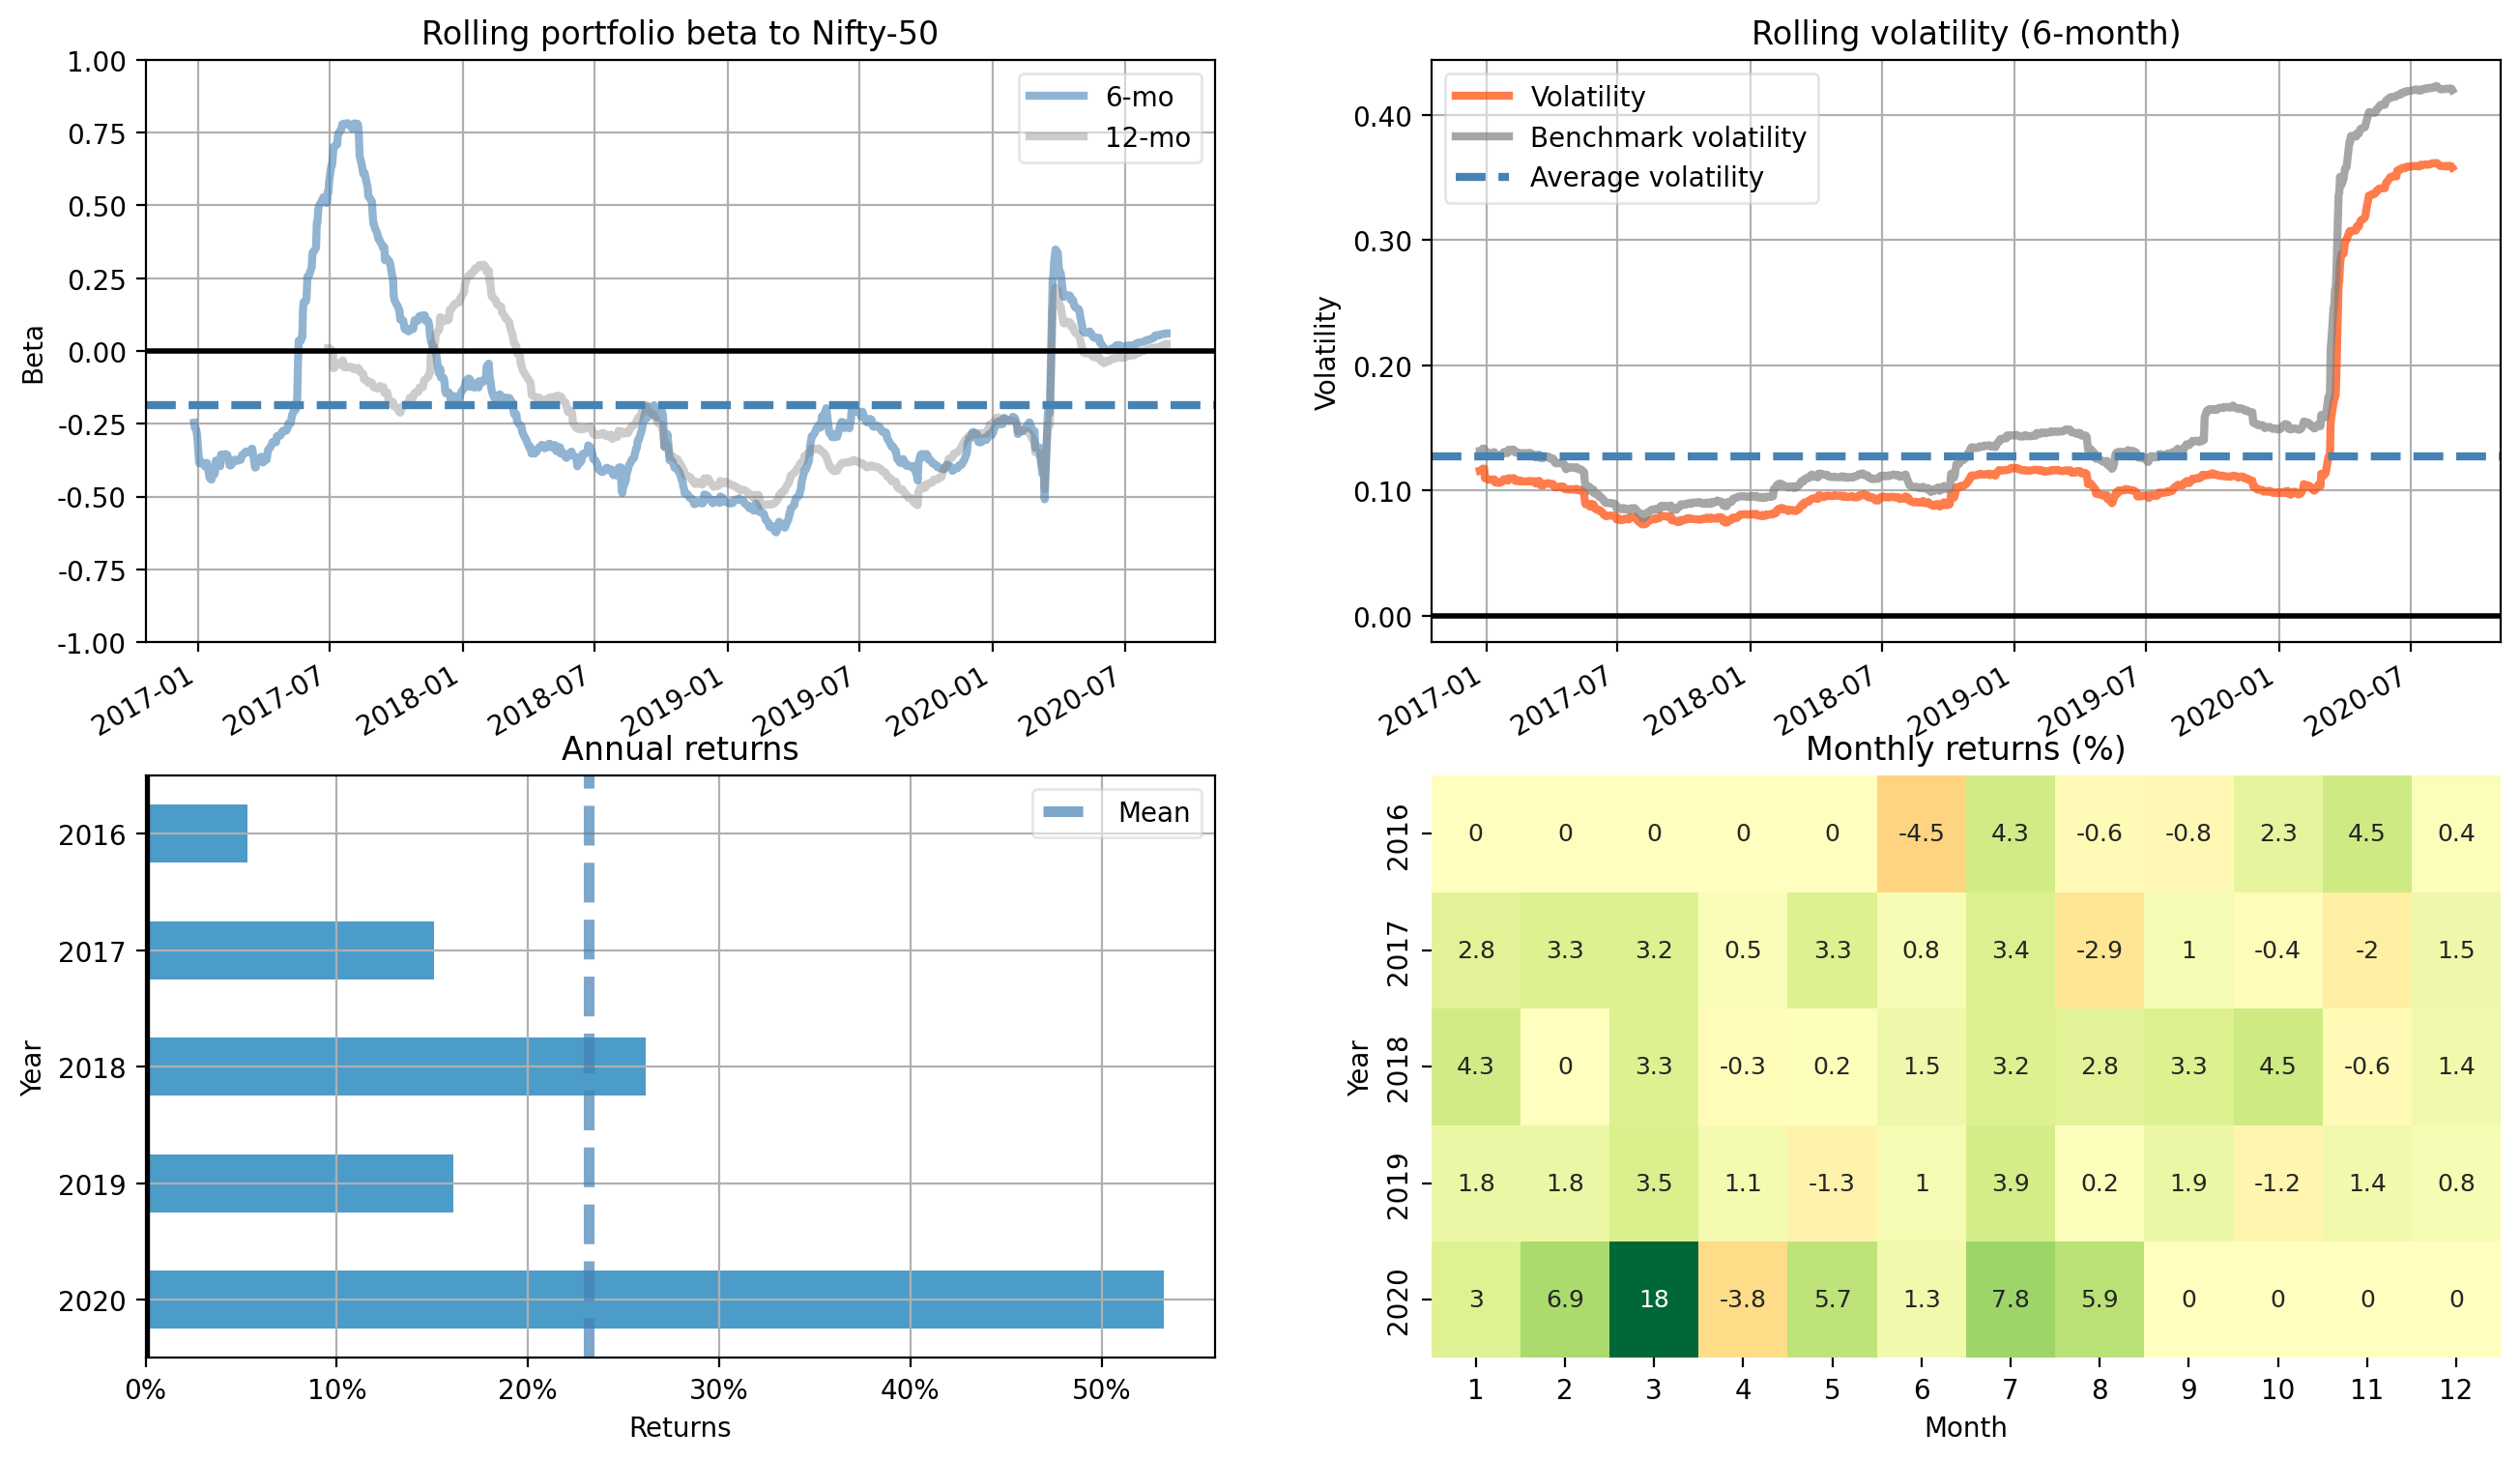

In [432]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[0])
axes[0].grid(True)

pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[1])
axes[1].grid(True)

pf.plot_annual_returns(returns=returns, ax=axes[2])
axes[2].grid(True)

pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[3],)
# fig.suptitle('XXX', fontsize=16, y=1.0)


plt.tight_layout()
plt.savefig('images/chart4', dpi=300)